# Figures pour le papier Digital Twins

In [1]:
from snake_ai.envs import RandomObstaclesEnv
from snake_ai.envs.geometry import Rectangle
import snake_ai.utils.visualization as vis

import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as splinalg
import tqdm

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.5.2 (SDL 2.28.4, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.13


[I 06/01/24 17:20:23.114 18325] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Définition des différences finies

In [2]:
def create_laplacian_matrix_2d(
    nx: int, ny: int, dx: float, dy: float
) -> sp.lil_array:
    Dxx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dyy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    return sp.kronsum(Dyy, Dxx, format="csr")


def create_laplacian_matrix_3d(
    nx: int, ny: int, nz: int, dx: float, dy: float, dz: float
) -> sp.lil_array:
    # Compute the 2D laplacian matrix
    laplace_2d = create_laplacian_matrix_2d(nx, ny, dx, dy)

    Dzz = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nz, nz)) / dz**2
    return sp.kronsum(Dzz, laplace_2d, format="csr")

In [3]:
# Definition of functions to convert between indices and subscripts
def ind2sub_2D(array_shape, ind):
    rows = (ind / array_shape[1])
    cols = ind % array_shape[1]
    return np.array([rows, cols], dtype='int')

def sub2ind_2D(array_shape, rows, cols):
    return int(rows*array_shape[1] + cols)

In [4]:
def apply_dirichlet_2D(A: sp.spmatrix, binary_map: np.ndarray):
    """Apply the Dirichlet boundary conditions to the linear system.

    Args:
        A (sp.spmatrix): Sparse matrix of the linear system Ax = b
        binary_map (np.ndarray): binary map of the domain, where 1 correspond to spaces to apply the boundary conditions 
    """
    res = binary_map.shape
    max_index = np.prod(res)
    rhs = np.zeros(max_index)
    assert A.shape == (max_index, max_index), "Shape mismatch between the matrix and the binary map"  

    rows, cols = np.nonzero(binary_map)   
    for i, j in tqdm.tqdm(zip(rows, cols), total=len(rows)):
        index = sub2ind_2D(res, i, j)
        
        A[index, index] = 1
        rhs[index] = binary_map[i, j]
        
        ind_o = sub2ind_2D(res, i + 1, j)
        ind_e = sub2ind_2D(res, i - 1, j)
        ind_n = sub2ind_2D(res, i, j + 1)
        ind_s = sub2ind_2D(res, i, j - 1)
        
        for neighbour_ind in [ind_o, ind_e, ind_n, ind_s]:
            # Set the row to the identity vector and apply the colums to rhs
            if neighbour_ind >= 0 and neighbour_ind < max_index:
                A[index, neighbour_ind] = 0
                rhs[neighbour_ind] -= A[neighbour_ind, index] * rhs[index]
                A[neighbour_ind, index] = 0
    return A, rhs

# Fonctions de visualisation

In [5]:
def compare_vector_field(vector_init, vector_final, goal, obstacles, downscale = 1, scale = 1, title="Trajectories comparision", init_pos = None):
    fig, ax = plt.subplots(dpi=300)
    X, Y = vector_init.meshgrid
        
    init_values = vector_init.values[::downscale, ::downscale]
    final_values = vector_final.values[::downscale, ::downscale]
    # if mask_updates:
    mask = np.linalg.norm(init_values - final_values, axis=-1) > 1e-3
    ## Draw patch for the goal and initial position
    ax.add_patch(plt.Circle(goal, 0.5, color="green"))
    if init_pos is not None:
        ax.add_patch(plt.Circle(init_pos, 0.5, color="blue"))
    ## Add transparency to the quiver plot
    ax.quiver(
        X[::downscale, ::downscale][~mask],
        Y[::downscale, ::downscale][~mask],
        init_values[~mask, 0],
        init_values[~mask, 1],
        units="xy",
        angles="xy",
        scale=scale,
        color="black",
        alpha=0.5,
    )
    ax.quiver(
        X[::downscale, ::downscale][mask],
        Y[::downscale, ::downscale][mask],
        final_values[mask, 0],
        final_values[mask, 1],
        units="xy",
        angles="xy",
        scale=scale,
        color="red",
    )
    ax.quiver(
        X[::downscale, ::downscale][mask],
        Y[::downscale, ::downscale][mask],
        init_values[mask, 0],
        init_values[mask, 1],
        units="xy",
        angles="xy",
        scale=scale,
        color="black",
    )
    
    for obs in obstacles:
        ax.add_patch(plt.Rectangle((obs.x, obs.y), obs.width, obs.height, color="red"))

    ax.set(title=title, xlabel="x")
    ax.set_ylabel('y', rotation=0)
    return fig

In [60]:
def compare_2D_trajectories(
    init_trajectories: np.ndarray,
    final_trajectories: np.ndarray,
    goal: np.ndarray,
    obstacles: List[Rectangle],
    title: str = "Trajectories comparision",
):
    """Plot the trajectories of multiple walkers in 2D with a color corresponding to their concentration.

    Args:
        init_trajectories (np.ndarray): positions before optimization
        final_trajectories (np.ndarray): positions after optimization
        goal (np.ndarray): position of the goal
        obstacles (List[Rectangle]): position of the goal
    """
    colormaps = ["viridis", "inferno", "plasma", "cividis", "magma"] + ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    assert isinstance(init_trajectories, np.ndarray) and init_trajectories.ndim == 3
    assert np.array_equal(init_trajectories[:,0], final_trajectories[:,0]), "Expected same initial positions"
    assert init_trajectories.shape == final_trajectories.shape, "Expected same shape"
    
    fig, ax = plt.subplots(1, 1, dpi=300)
    for i in range(init_trajectories.shape[0]):
        ax.scatter(
            init_trajectories[i, :, 0],
            init_trajectories[i, :, 1],
            c=np.arange(init_trajectories.shape[1]),
            cmap=colormaps[0],
            marker=".",
        )
        ax.scatter(
            final_trajectories[i, :, 0],
            final_trajectories[i, :, 1],
            c=np.arange(final_trajectories.shape[1]),
            cmap=colormaps[1],
            # linestyle="-",
            marker=".",
        )
    for obs in obstacles:
        ax.add_patch(plt.Rectangle((obs.x, obs.y), obs.width, obs.height, color="red"))
    ax.add_patch(plt.Circle(goal, 0.5, color="green"))
    ax.add_patch(plt.Circle(init_trajectories[0,0], 0.5, color="blue"))
    ax.set(title=title, xlabel="x", ylabel="y")
    return fig

In [6]:
from matplotlib.patches import Ellipse

def plot_error_ellipse(ax, mean, cov, n_std=1, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    """
    # Calculate the eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)

    # Compute "tilt" of ellipse using first eigenvector
    x, y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))

    # Eigenvalues give length of ellipse along each eigenvector
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, facecolor=facecolor, **kwargs)

    ax.add_patch(ellipse)

def compare_2D_trajectories_mean(init_trajectories : np.ndarray, final_trajectories : np.ndarray, goal, obstacles, title="Trajectories comparision", step_size=10):
    assert isinstance(init_trajectories, np.ndarray) and init_trajectories.ndim == 3
    assert isinstance(final_trajectories, np.ndarray) and init_trajectories.ndim == 3
    assert np.array_equal(init_trajectories[:,0], final_trajectories[:,0]), "Expected same initial positions"
    assert init_trajectories.shape == final_trajectories.shape, "Expected same shape"
    t_max = init_trajectories.shape[1]

    fig, ax = plt.subplots(1, 1, dpi=300)
    
    mean_init = np.mean(init_trajectories, axis=0)
    mean_final = np.mean(final_trajectories, axis=0)
    ax.plot(mean_init[:, 0], mean_init[:, 1], c="blue", label="Initial trajectories")
    ax.plot(mean_final[:, 0], mean_final[:, 1], c="orange", label="Final trajectories")
        
    # Plot the initial trajectories
    for t in range(0, t_max, step_size):
        cov_init = np.cov(init_trajectories[:, t, :].T)
        plot_error_ellipse(ax, mean_init[t], cov_init, n_std=1, edgecolor='blue', linestyle='--')
        cov_final = np.cov(final_trajectories[:, t, :].T)
        plot_error_ellipse(ax, mean_final[t], cov_final, n_std=1, edgecolor='orange', linestyle='--')   
 
    # Plot obstacles and goal
    for obs in obstacles:
        ax.add_patch(plt.Rectangle((obs.x, obs.y), obs.width, obs.height, color="red"))
    ax.add_patch(plt.Circle(goal, 0.5, color="green"))
    
    ax.set(title=title, xlabel="x", ylabel="y")
    fig.legend(loc='upper right')
    return fig

# Definition d'environement à partir de carte binaires 

In [130]:
binary_map = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])
binary_map.shape

obstacles = [Rectangle(x, y, 1, 1) for x, y in zip(*np.where(binary_map == 1))]


In [131]:
res = 20
x_max, y_max = binary_map.shape

new_obs_map = np.zeros((x_max * res, y_max * res))
for x, y in np.argwhere(binary_map):
    new_obs_map[x*res:(x+1)*res, y*res:(y+1)*res] = 1

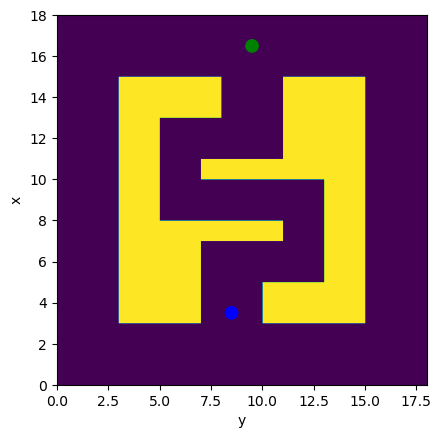

In [132]:
init_pos = np.array([3.5, 8.5])
goal_pos = np.array([16.5, 9.5])
fig, ax = plt.subplots()
ax.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])
ax.set(xlabel='y', ylabel='x')
ax.add_patch(plt.Circle(init_pos[::-1], 0.3, color="blue"))
ax.add_patch(plt.Circle(goal_pos[::-1], 0.3, color="green"))   

100%|██████████| 1/1 [00:00<00:00, 1076.84it/s]


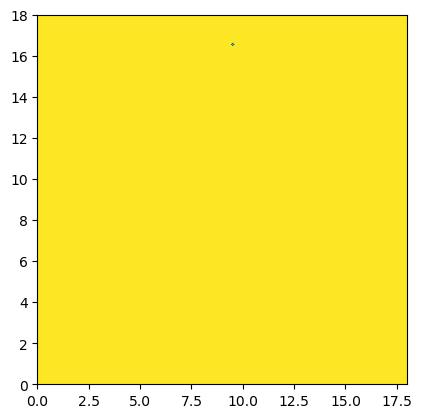

In [133]:
## 
step = np.array(binary_map.shape) / np.array(new_obs_map.shape)
laplace = create_laplacian_matrix_2d(*new_obs_map.shape, *step)
rhs = np.zeros(new_obs_map.shape)
goal_ind = np.array(goal_pos * res, dtype=int)
rhs[goal_ind[0], goal_ind[1]] = 1e3
laplace, rhs = apply_dirichlet_2D(laplace, rhs)
plt.imshow(rhs.reshape(new_obs_map.shape), origin='lower', extent=[0, x_max, 0, y_max])
# plt.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])

In [134]:
valid_ind = new_obs_map.flat == 0
A = laplace[valid_ind][:, valid_ind]
b = rhs.flat[valid_ind]
x = splinalg.spsolve(A, b)
solution = np.zeros(new_obs_map.shape, dtype=float)
solution.flat[valid_ind] = x

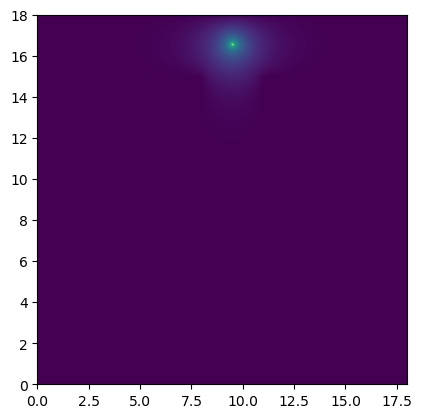

In [135]:
plt.imshow(solution, origin='lower', extent=[0, x_max, 0, y_max])


## Now let's run differentiable simulations
Here we want to run a simulation with bending constraints.

In [136]:
import taichi as ti
import taichi.math as tm
from  snake_ai.diffsim.walk_simulation import WalkerSimulationStoch2D
from snake_ai.diffsim.field import ScalarField
from typing import List

@ti.data_oriented
class BendingSimulation(WalkerSimulationStoch2D):
    def __init__(self, positions: np.ndarray, potential_field: ScalarField, obstacles: List[Rectangle] = None, t_max: float = 100, dt: float = 0.1, diffusivity: float = 1):
        super().__init__(positions, potential_field, obstacles, t_max, dt, diffusivity) 
        self.distance_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.bending_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.total_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)

    @ti.kernel
    def reset(self):
        for n in ti.ndrange(self.nb_walkers):
            self.states[n, 0].pos = self._init_pos[n]
            self.states[n, 0].vel = tm.vec2(0.0, 0.0)
            for t in ti.ndrange(self.nb_steps):
                self._noise[n, t] = tm.vec2(ti.randn(), ti.randn())
        for i, j in self.force_field._values:
            self.force_field._values.grad[i, j] = tm.vec2(0.0, 0.0)
        self.distance_loss[None] = 0.0
        self.bending_loss[None] = 0.0
        self.total_loss[None] = 0.0

    
    @ti.kernel
    def compute_distance_loss(self, target : ti.template(), t : int):
        for n in range(self.nb_walkers):
            ti.atomic_add(self.distance_loss[None], tm.length(self.states[n, t].pos - target)**2)
    
    @ti.kernel
    def compute_bending_loss(self):
        for n in range(self.nb_walkers):
            for t in range(self.nb_steps - 1):
                F_t1 = self.force_field._at_2d(self.states.pos[n, t])
                F_t2 = self.force_field._at_2d(self.states.pos[n, t + 1])
                bending = tm.atan2(tm.cross(F_t1, F_t2), tm.dot(F_t1, F_t2))
                ti.atomic_add(self.bending_loss[None], bending ** 2)
                
    @ti.kernel
    def compute_total_loss(self, distance : float, bending : float):
        self.total_loss[None] = distance * self.distance_loss[None] + bending * self.bending_loss[None]

In [137]:
ti.init(arch=ti.gpu)

nb_agents = 20
t_max = 50
dt = 0.1
diffusivity = 0.01

positions = np.repeat(init_pos.reshape(1, 2), nb_agents, axis=0)
field = ScalarField(solution, Rectangle(0, 0, x_max, y_max))
bending_sim = BendingSimulation(positions, field, t_max=t_max, dt=dt, diffusivity=diffusivity, obstacles=obstacles)
bending_sim.reset()
bending_sim.run(diffusivity)
bending_sim.compute_bending_loss()
bending_sim.compute_distance_loss(tm.vec2(goal_pos), t_max - 1)
bending_sim.compute_total_loss(1, 1)

print(f"bending : {bending_sim.bending_loss[None]}, distance : {bending_sim.distance_loss[None]}, total : {bending_sim.total_loss[None]}")

[Taichi] Starting on arch=cuda
bending : 28246.572265625, distance : 1980.7259521484375, total : 30227.298828125


(0.0, 18.0)

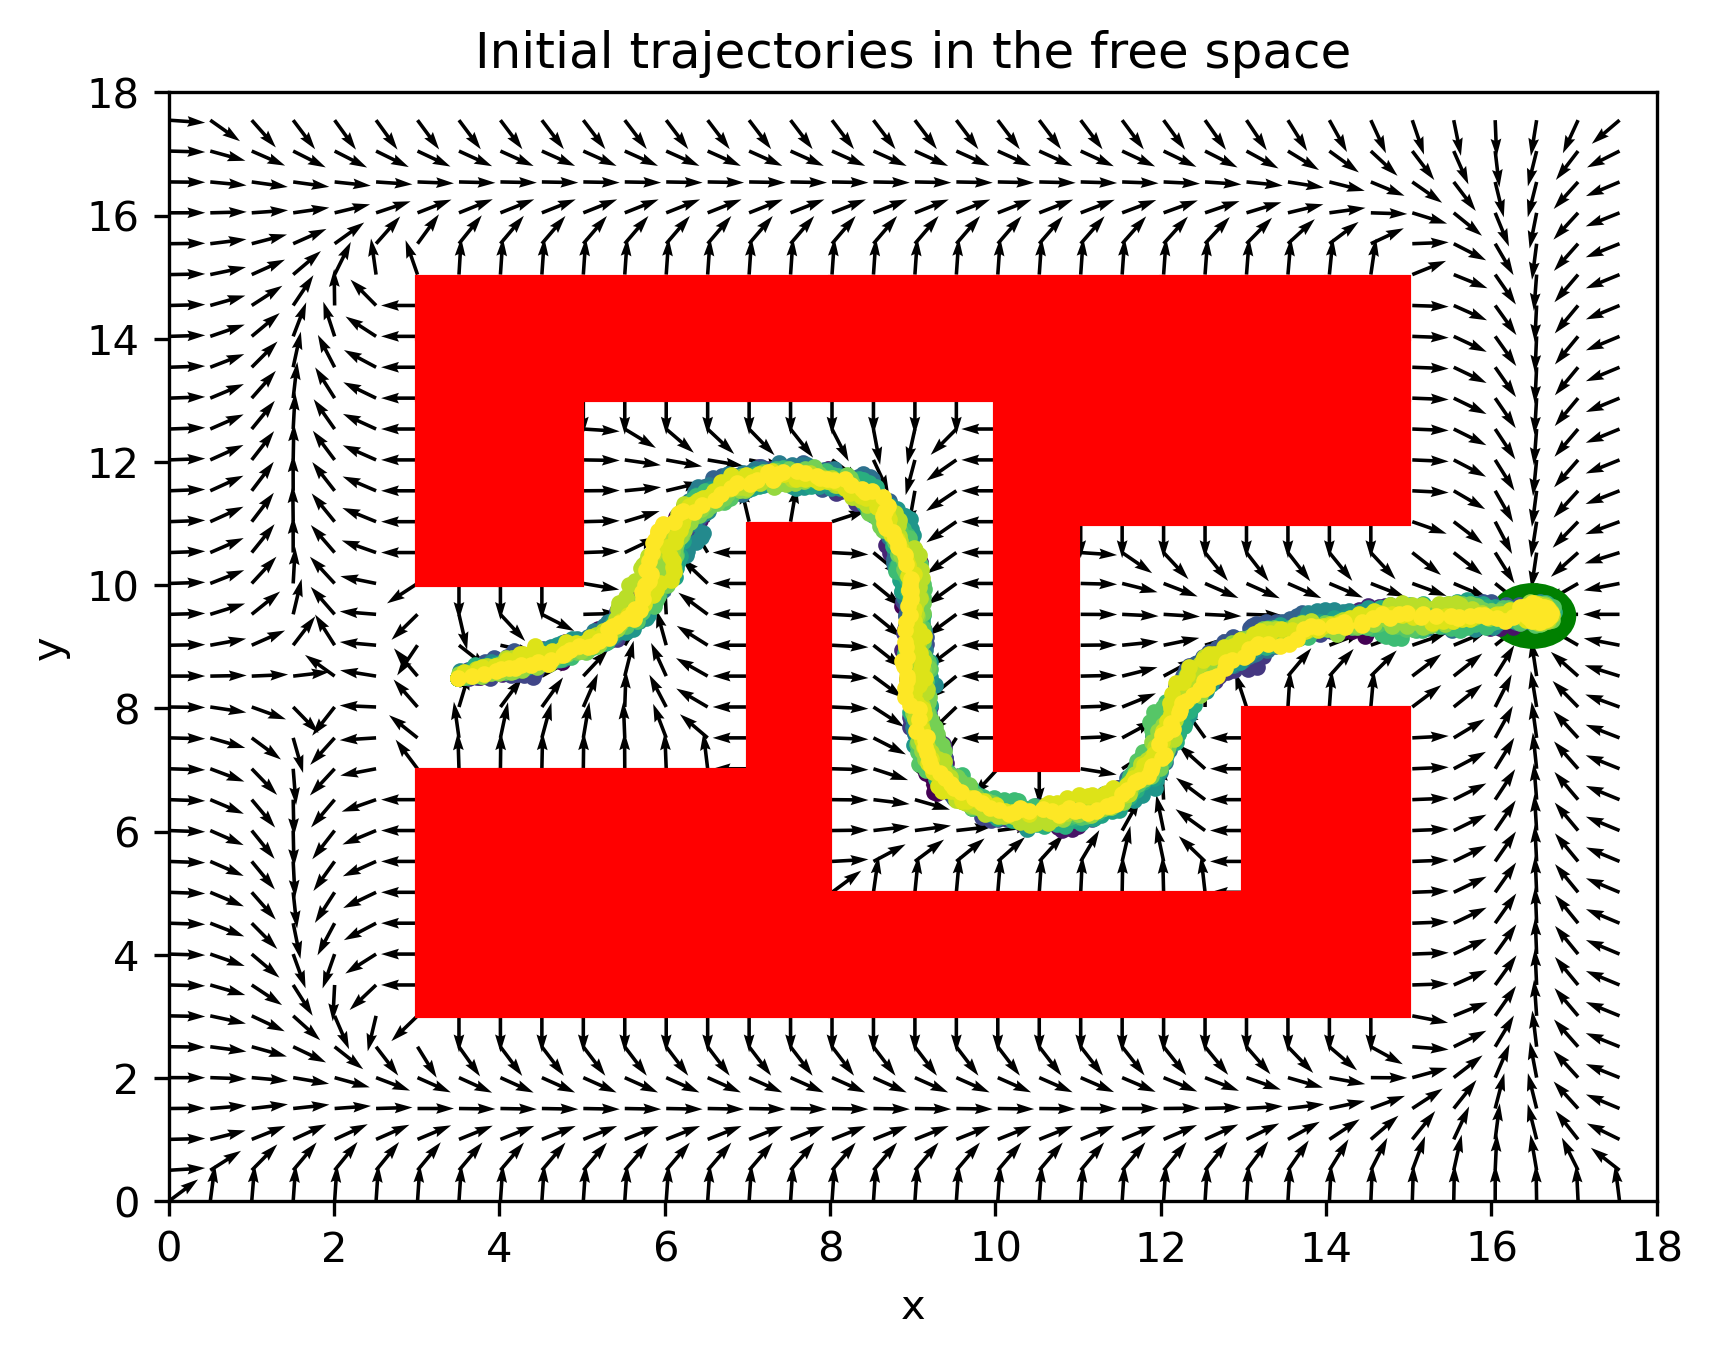

In [138]:
downscale = 10
scale = 2
# Visualisation
fig = vis.plot_2D_trajectory(bending_sim.positions, 
                             goal_pos, 
                             obstacles=obstacles, 
                             vector_field=bending_sim.force_field, 
                             downscale=downscale, 
                             scale = scale, 
                             title="Initial trajectories in the free space")
plt.xlim(0, x_max)
plt.ylim(0, y_max)

In [71]:
fig.savefig("figures/bending_initial_trajectories.svg")

In [99]:
from snake_ai.diffsim.field import VectorField
# Save the initial force field
init_trajectories = np.copy(bending_sim.positions)

values = np.copy(bending_sim.force_field.values)
_bounds = bending_sim.force_field._bounds
print(values.shape)
values = np.stack([values[:,:,0], values[:,:,1]], axis=0)
print(values.shape)
bound = Rectangle(*_bounds.min, _bounds.width(), _bounds.height()) 
force_field_init = VectorField(values, bound)

(360, 360, 2)
(2, 360, 360)


We can now try to optimize the force field to limit bending

In [102]:
max_iter = 200
lr = 0.01
clip = 10.
diffusivity=0.2
# diffusivities = np.linspace(1, 0.1, max_iter)

w_distance, w_bend = 1.0, 10.0

best_loss = np.inf
best_vector_field = None

target = tm.vec2(goal_pos)
for iter in range(max_iter):
    bending_sim.reset()
    with ti.ad.Tape(bending_sim.total_loss):
        bending_sim.run(diffusivity=diffusivity)
        # bending_sim.run(diffusivity=diffusivities[iter])
        bending_sim.compute_distance_loss(target, bending_sim.nb_steps - 1)
        bending_sim.compute_bending_loss()
        bending_sim.compute_total_loss(w_distance, w_bend)
    # if bending_sim.total_loss[None] < best_loss:
    #     best_loss = bending_sim.total_loss[None]
    #     best_vector_field = np.copy(bending_sim.force_field._values.to_numpy())
    print("Iter=", iter, "Loss=", bending_sim.total_loss[None], "Distance=", bending_sim.distance_loss[None], "Bending=", bending_sim.bending_loss[None])
    if clip > 0:
        bending_sim.clip_force_field(clip)
    bending_sim._update_force_field(lr)

Iter= 0 Loss= 105730.6796875 Distance= 5.2131242752075195 Bending= 10572.546875
Iter= 1 Loss= 109751.8828125 Distance= 4.059431076049805 Bending= 10974.7822265625
Iter= 2 Loss= 112249.53125 Distance= 2.9587912559509277 Bending= 11224.6572265625
Iter= 3 Loss= 107445.734375 Distance= 3.9752917289733887 Bending= 10744.17578125
Iter= 4 Loss= 107289.03125 Distance= 5.062905788421631 Bending= 10728.396484375
Iter= 5 Loss= 107056.796875 Distance= 2.984589099884033 Bending= 10705.380859375
Iter= 6 Loss= 107961.578125 Distance= 3.0806736946105957 Bending= 10795.849609375
Iter= 7 Loss= 107596.8515625 Distance= 3.432157278060913 Bending= 10759.341796875
Iter= 8 Loss= 114346.8671875 Distance= 2.8845152854919434 Bending= 11434.3984375
Iter= 9 Loss= 110366.3125 Distance= 2.276249408721924 Bending= 11036.4033203125
Iter= 10 Loss= 114924.359375 Distance= 3.3713436126708984 Bending= 11492.0986328125
Iter= 11 Loss= 113247.1015625 Distance= 4.435131549835205 Bending= 11324.2666015625
Iter= 12 Loss= 12013

(0.0, 18.0)

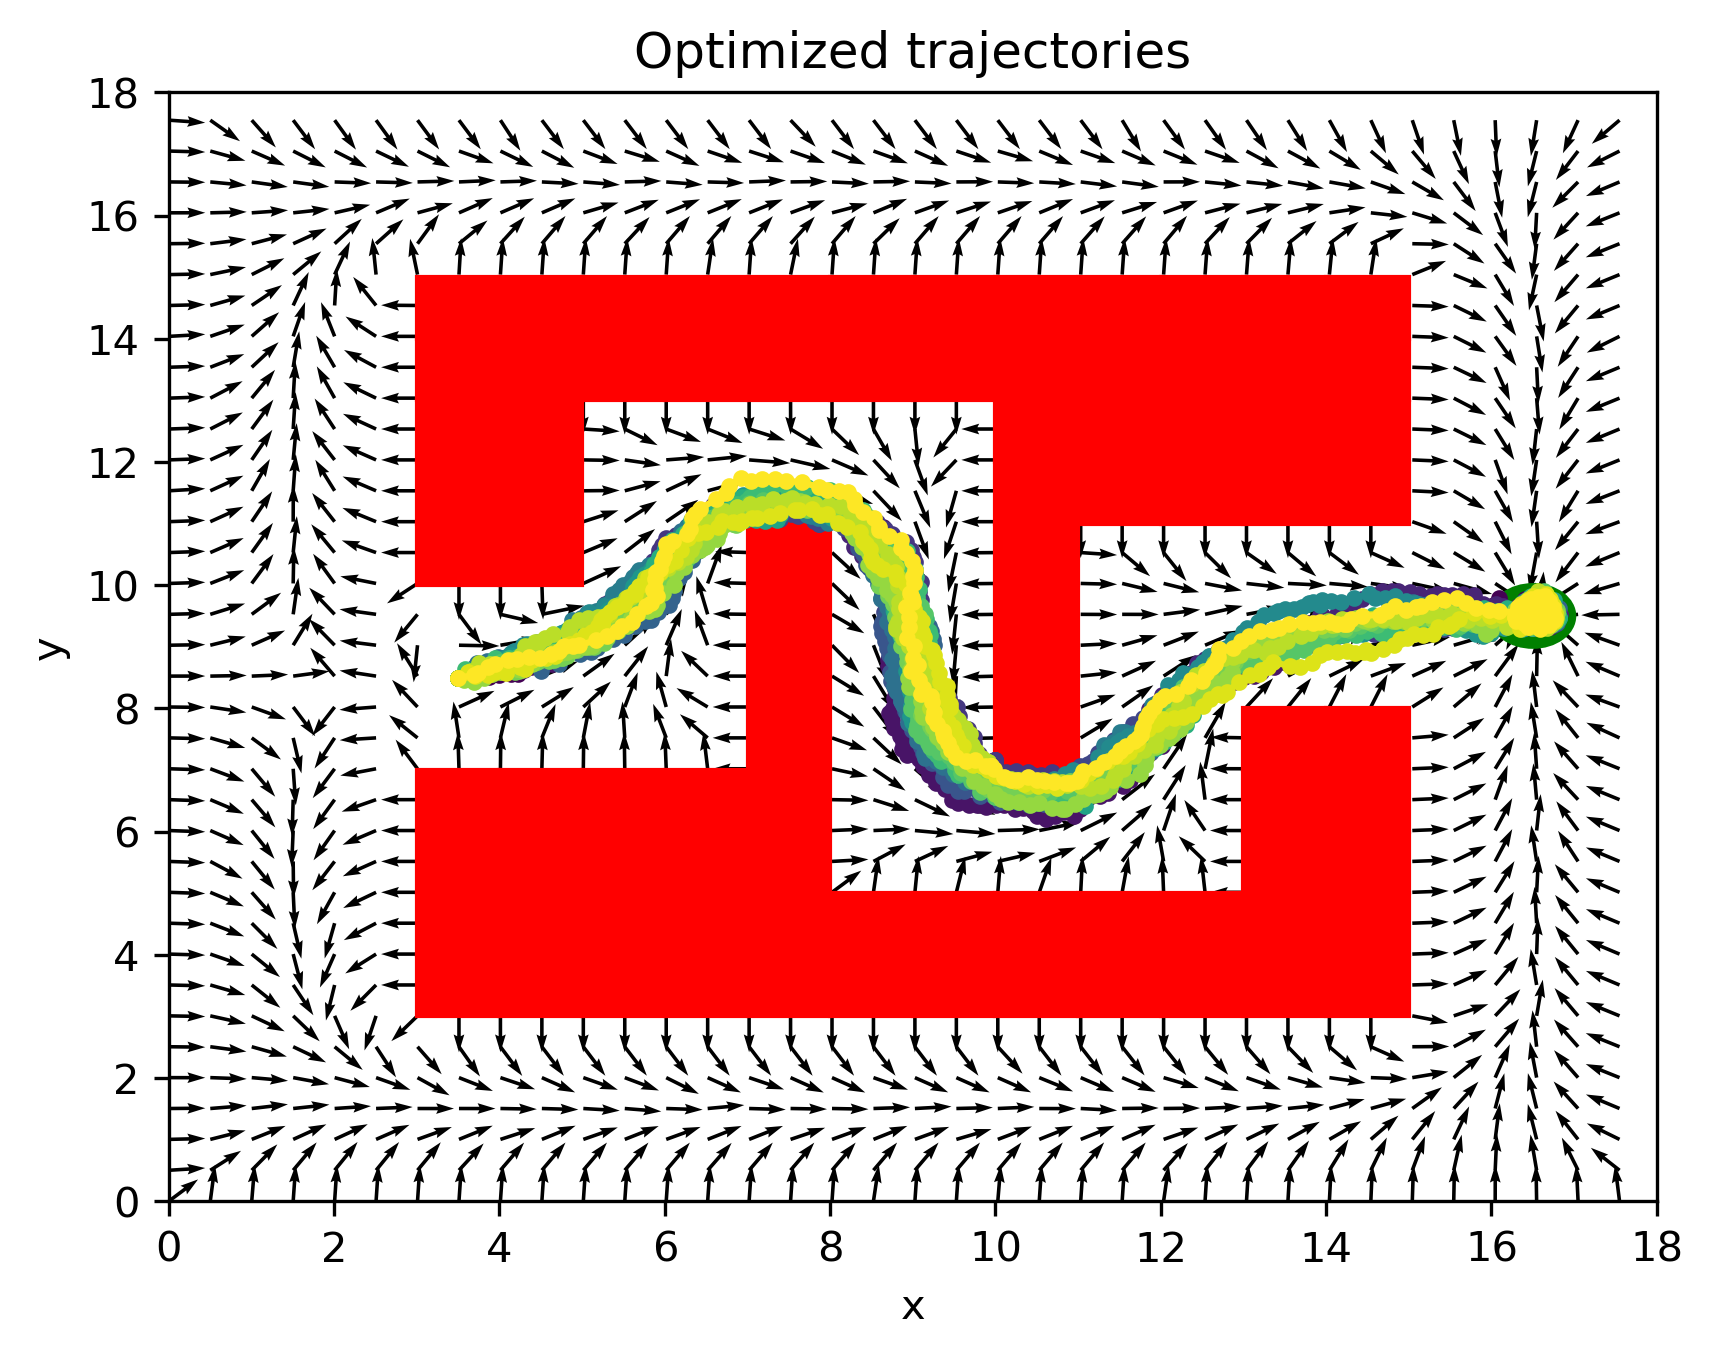

In [103]:
downscale = 10
scale = 2

bending_sim.reset()
bending_sim.run(diffusivity=0.01)
# Visualisation
fig = vis.plot_2D_trajectory(bending_sim.positions, 
                             goal_pos, 
                             obstacles=obstacles, 
                             vector_field=bending_sim.force_field, 
                             downscale=downscale, 
                             scale = scale, 
                             title="Optimized trajectories")
plt.xlim(0, x_max)
plt.ylim(0, y_max)

In [64]:
fig.savefig("figures/optimized_bending_trajectories.svg")

(0.0, 18.0)

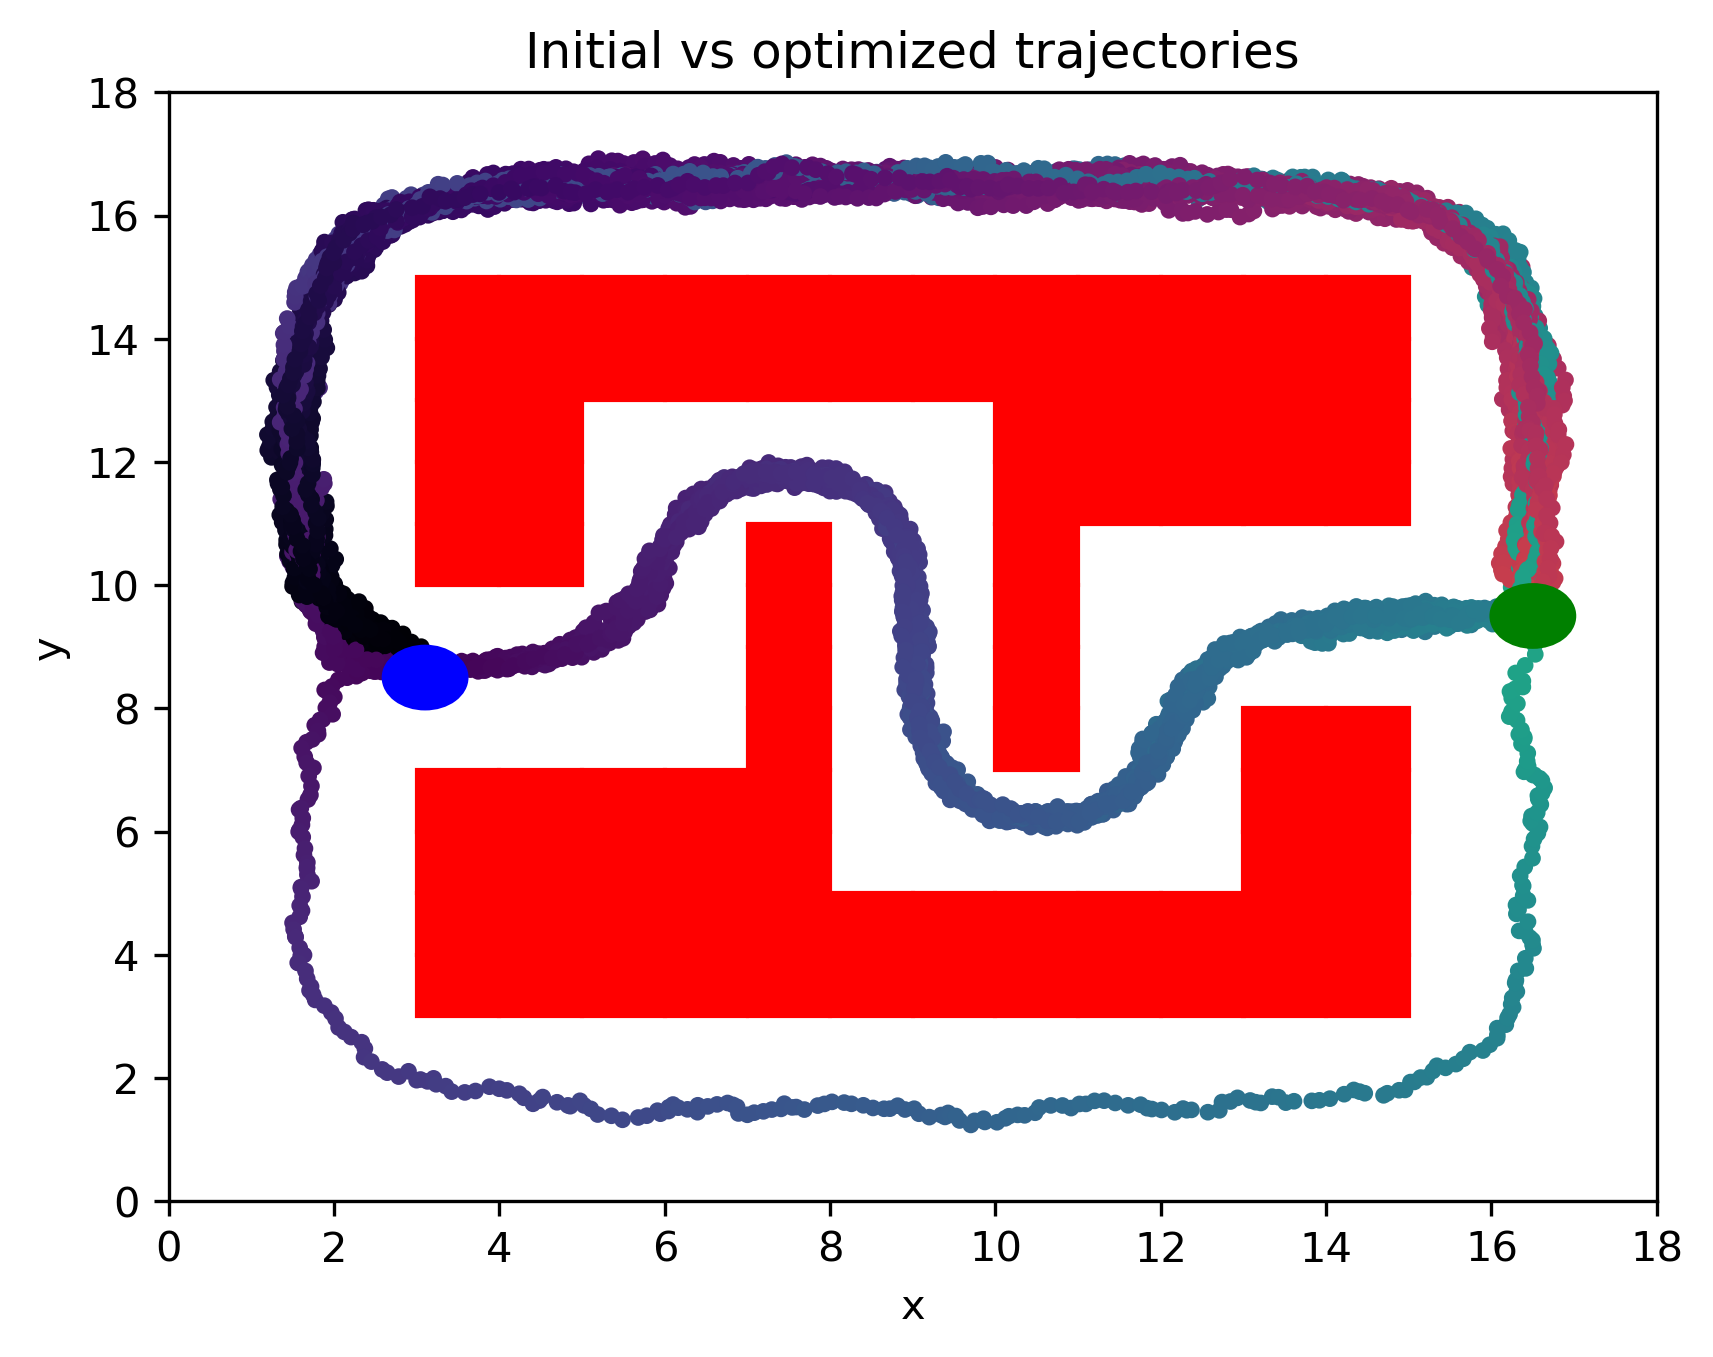

In [65]:
fig = compare_2D_trajectories(init_trajectories, bending_sim.positions, goal_pos, obstacles, title="Initial vs optimized trajectories")
plt.xlim(0, x_max)
plt.ylim(0, y_max)

In [66]:
fig.savefig("figures/optimized_bending_trajectories_comparision.svg")

(0.0, 18.0)

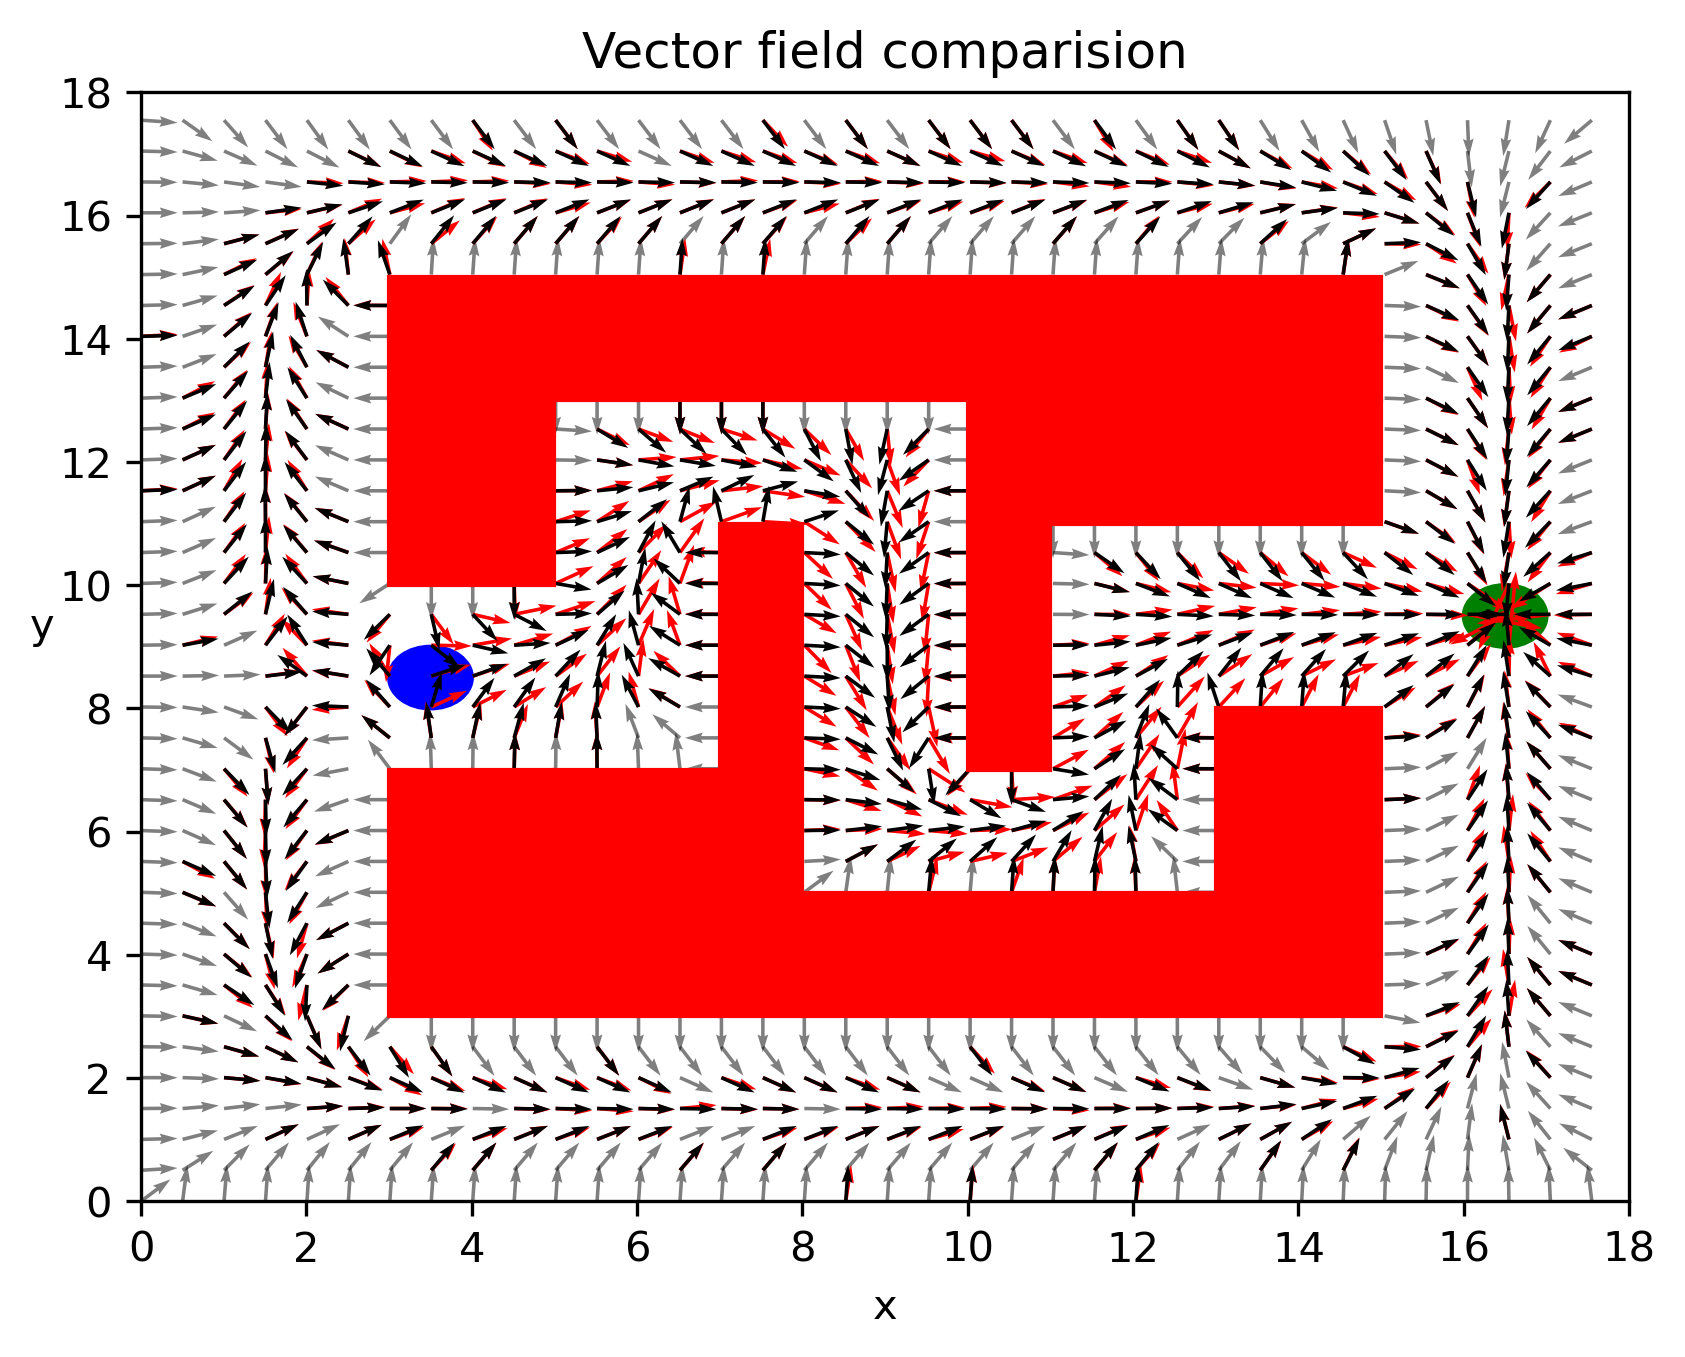

In [105]:
downscale, scale = 10, 2
fig = compare_vector_field(force_field_init, bending_sim.force_field, goal_pos, obstacles, downscale, scale, title="Vector field comparision", init_pos=init_pos)
plt.xlim(0, x_max)
plt.ylim(0, y_max)

In [106]:
fig.savefig("figures/optimized_bending_force_field_bis.svg")

(0.0, 18.0)

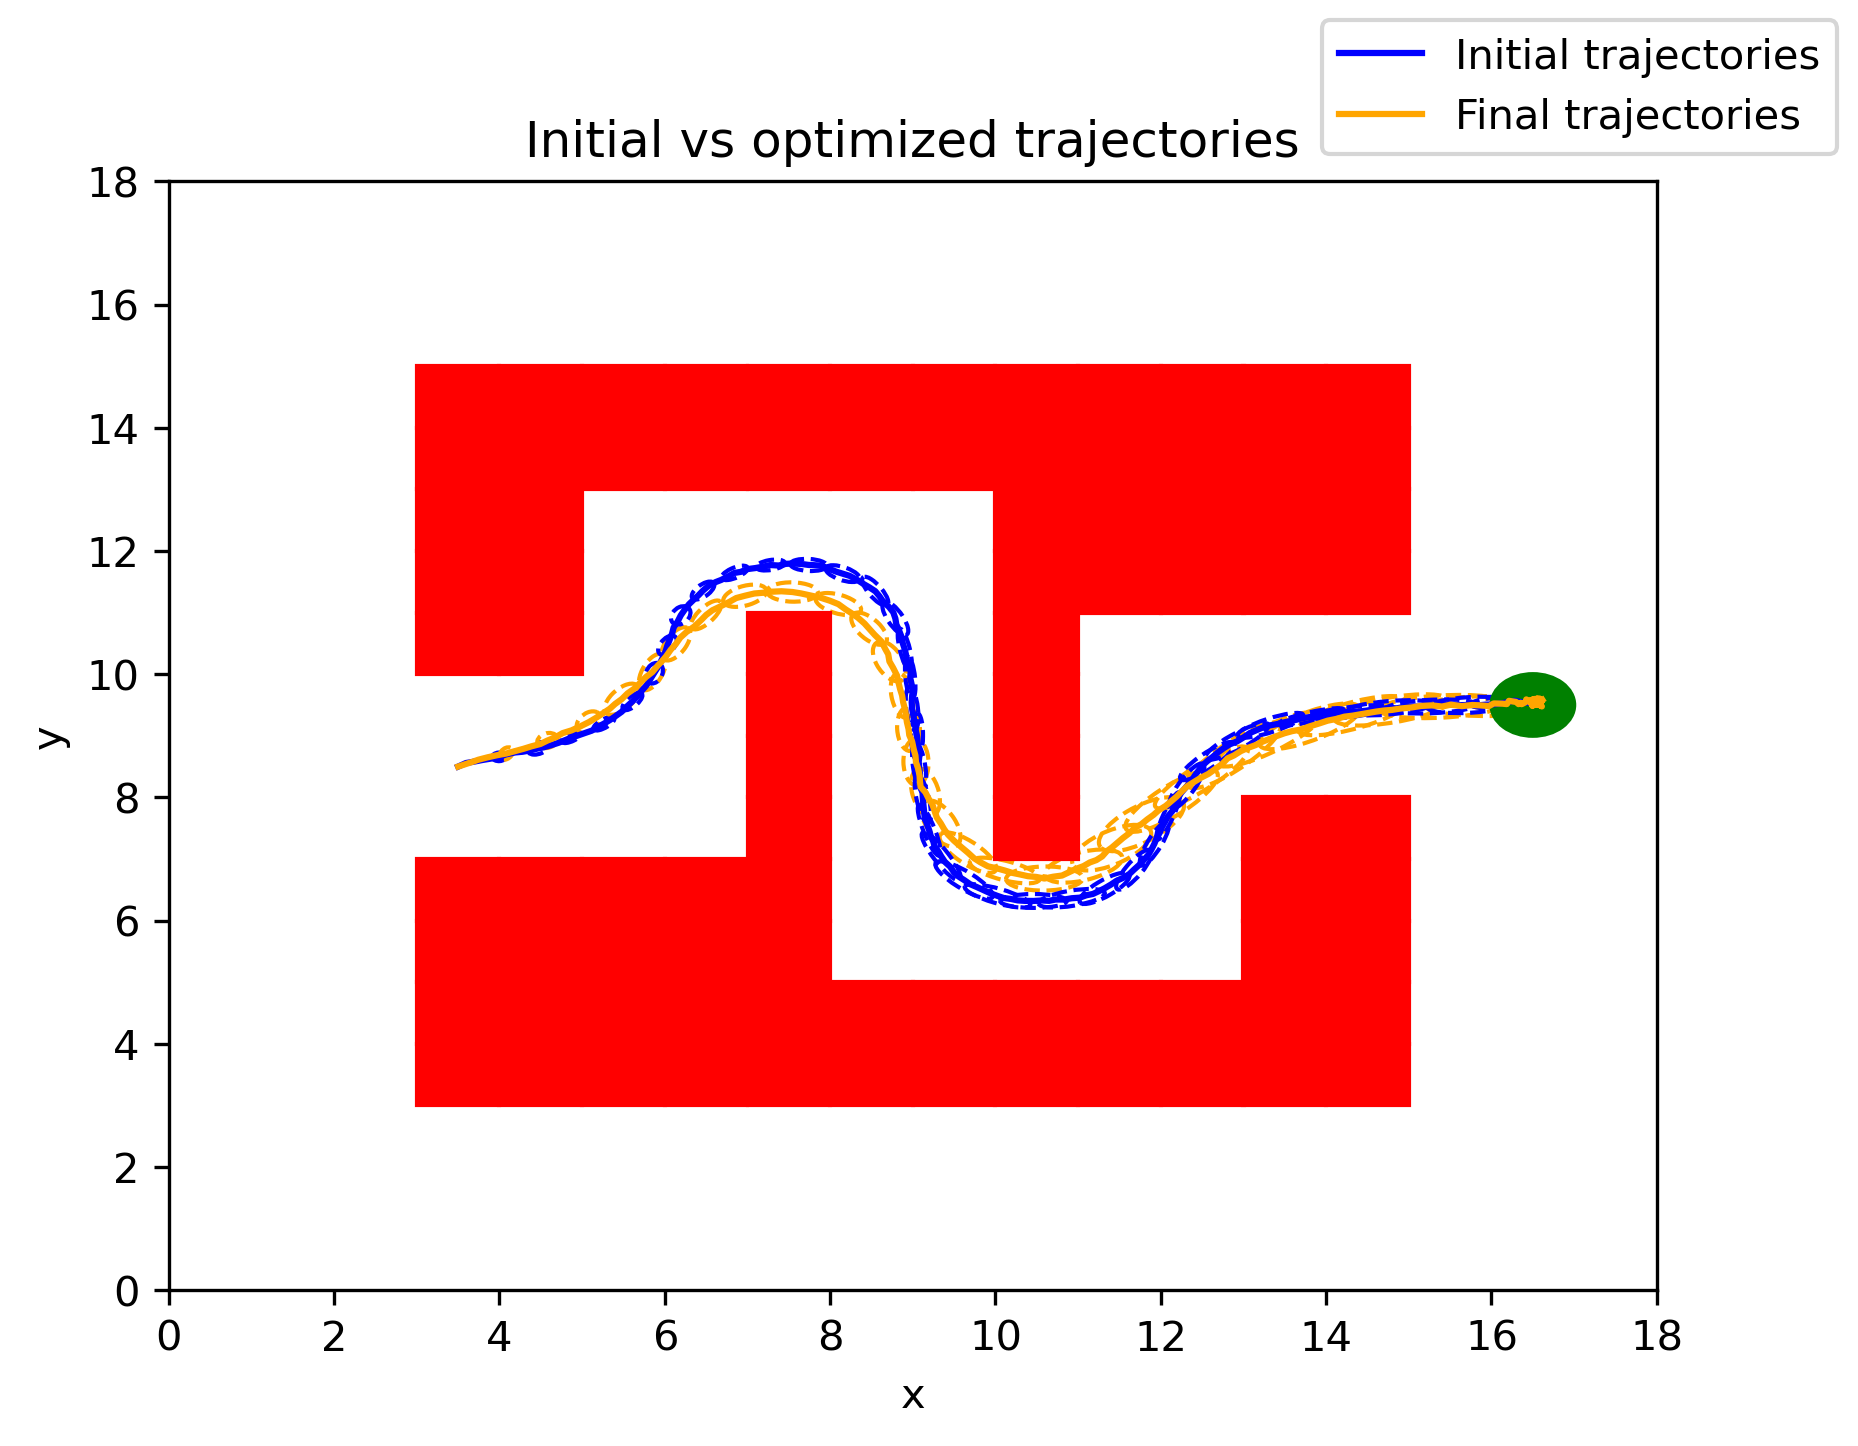

In [110]:
fig = compare_2D_trajectories_mean(init_trajectories, bending_sim.positions, goal_pos, obstacles, title="Initial vs optimized trajectories", step_size=5)
plt.xlim(0, x_max)
plt.ylim(0, y_max)

In [111]:
fig.savefig("figures/optimized_bending_trajectories_mean.svg")